In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split, KFold
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC             
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score

## Reading the data in

In [2]:
# Reading the data in
data = pd.read_csv('heart_data.csv', # the dataset 
                   sep='\,', # seperator
                   header=None, # to avoid error, ignore header
                   engine='python', # define engine
                   names=['index','id','age','gender','height','weight','ap_hi',  
                          'ap_lo','cholesterol','gluc','smoke','alco','active',
                          'cardio']).apply(lambda x: x.str.replace(r"\"","",
                                                                   regex=True))

In [3]:
# Peak
data.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
2,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
3,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
4,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1


## Data Cleaning

In [4]:
# Discard first row, reset index
data = data.loc[1:,:].reset_index(drop=True)

data.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# Also drop reduntant columns such as  id, and 'index'
data = data.drop(['index', 'id'], 
                 axis=1)
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
# Convert all data to numeric dtypes, floats
data = data.astype('float')

data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393.0,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
1,20228.0,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0
2,18857.0,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0
3,17623.0,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,0.0,1.0,1.0
4,17474.0,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0


Fixing the `age` column. As it seems to be in days.

In [7]:
# Diving age by 360, number of days in an year
data['age'] = data['age']/360

data['age'].head()

0    51.091667
1    56.188889
2    52.380556
3    48.952778
4    48.538889
Name: age, dtype: float64

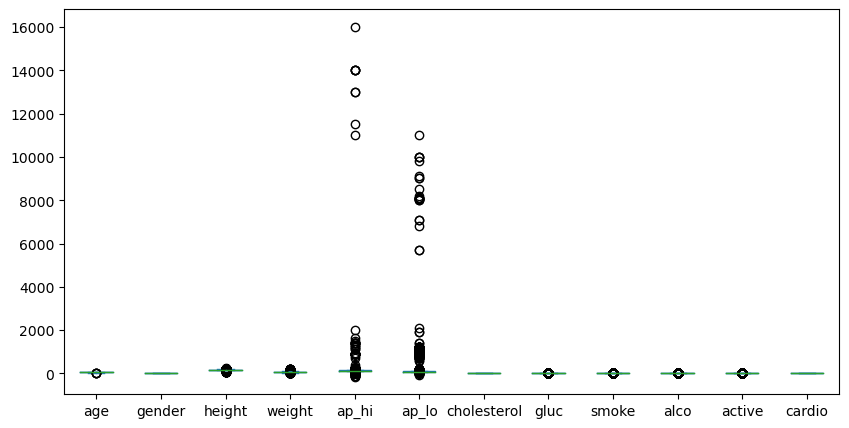

In [8]:
# Outliers and Distribution
data.plot.box(figsize=(10,5))
plt.show()

- The columns are on multiple scales, hence it is not helpful to understand outliers at this stage

In [9]:
# cheking for duplicates
data.duplicated().sum()

24

In [10]:
# Removal of Duplicates

print('Before removal of duplicates: ', data.shape[0])
data = data.drop_duplicates()
print('After removal of duplicates: ', data.shape[0])

Before removal of duplicates:  70000
After removal of duplicates:  69976


## Data Analysis

In [ ]:
sns.pairplot(data, 
             hue='cardio')
plt.show()

- There data does not seem to be linearly seperable, atleast on 2D.
- For a linear algorithm, It will be interesting to see how SVM will work on it with its kernel trick
- Tree algorithms such as Decision Trees and Random Forest might also work well on this dataset

Before going further, lets see how can we improve respresestation of data. Much of it would be about further cleaning it for low variance features, duplicates and null values

In [ ]:
# General information
data.info()

In [ ]:
# Statistical Information
data.describe()

In [ ]:
# Gather continuous cols
continuous_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Gather Discrete cols
discrete_cols = [col for col in data.columns if col not in continuous_cols]

In [ ]:
for col in discrete_cols:
    print('-'*50)
    print(col)
    print(data[col].value_counts(dropna=False))

- Columns such as `alco`, `smoke` seems to be very unbalanced. 
- Whereas the target variable `Cardio` seems to be highly balanced.

Lets keep `alco` and `smoke` under observation

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

For linear algorithms, I will remove the following columns as they seem to have highly colinearity with some of the other dependent variables.
1. `smoke`
2. `gender`
3. `alco`

And move on to check other columns that are causing multicolinearity

In [151]:
# the independent variables set
X = data.iloc[:,:-1]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

        feature        VIF
0           age  55.628166
1        gender  11.751168
2        height  97.483887
3        weight  31.094964
4         ap_hi   1.701582
5         ap_lo   1.266182
6   cholesterol   6.530257
7          gluc   7.038203
8         smoke   1.366361
9          alco   1.203871
10       active   5.055668


- `gender`, `height` and, `weight seems to have very high VIF.

After trying out one by one for each, I found that deleting all of these reaped better results (i-e, lower VIF)

In [152]:
X = data.drop(['smoke', 'alco', 'gender', 'height', 'weight'],
              axis=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

       feature        VIF
0          age  11.653079
1        ap_hi   1.693380
2        ap_lo   1.265841
3  cholesterol   6.636864
4         gluc   6.908252
5       active   4.798708
6       cardio   2.184211


In [153]:
# The following dataset does not have colinear and unbalanced columns and intended to be used for Linear models
dfl = data.drop(['smoke', 'alco', 'gender', 'height', 'weight'], 
                axis=1)

dfl.head()

,age,ap_hi,ap_lo,cholesterol,gluc,active,cardio
0,51.091667,110.0,80.0,1.0,1.0,1.0,0.0
1,56.188889,140.0,90.0,3.0,1.0,1.0,1.0
2,52.380556,130.0,70.0,3.0,1.0,0.0,1.0
3,48.952778,150.0,100.0,1.0,1.0,1.0,1.0
4,48.538889,100.0,60.0,1.0,1.0,0.0,0.0


---
### Towards Model Building
##### Splitting and Training the datasets for linear models

In [224]:
# Dependent variables
X = dfl.drop('cardio', axis=1)

# Target
y = dfl['cardio']

In [225]:
# Splitting the dataset futher
X_train, X_test, y_train, y_test = train_test_split(X,  
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1234)

In [226]:
# Scaling
scaler = StandardScaler()

# Appling scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [227]:
# Instantiate Logistic Regression
logreg = LogisticRegression()

# Fit the model
logreg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7187633973229172


C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


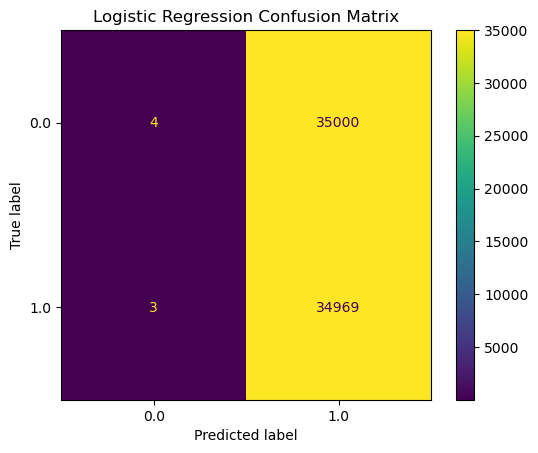

In [228]:
plot_confusion_matrix(logreg, X, y)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [229]:
# Instantiate Linear SVM
svm = LinearSVC(C=50)

# Fit the model
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7139522698042204


C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


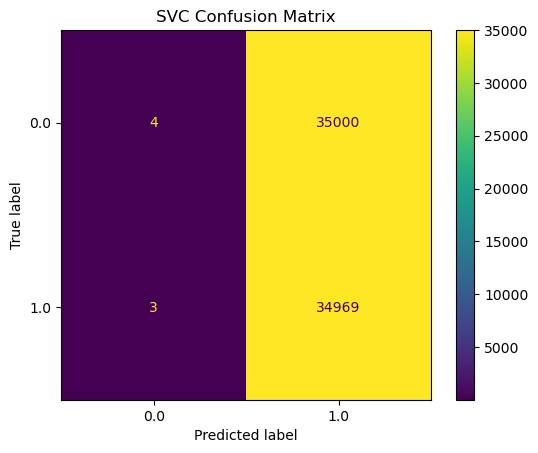

In [230]:
plot_confusion_matrix(svm, X, y)
plt.title('SVC Confusion Matrix')
plt.show()

- <font color='red'> Linear models failed to capture data

##### Splitting and training dataset for tree based models

In [231]:
# Dependent variables
X = data.drop('cardio', axis=1)

# Target
y = data['cardio']

In [232]:
# Splitting the dataset futher
X_train, X_test, y_train, y_test = train_test_split(X,  
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1234)

In [233]:
# Instantiate Decision Tree
dtree = DecisionTreeClassifier()

# Fit the model
dtree.fit(X_train, y_train)

# Make predictions
y_pred = dtree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6266076021720491


C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


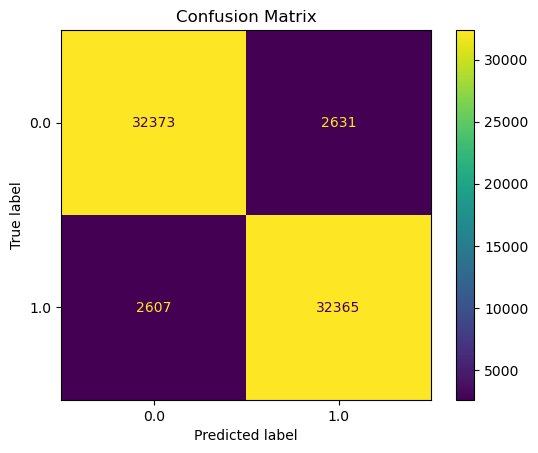

In [234]:
plot_confusion_matrix(dtree, X, y)
plt.title('Confusion Matrix')
plt.show()

In [235]:
# Instantiate Random Forest Classifier
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7149185481566162


C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


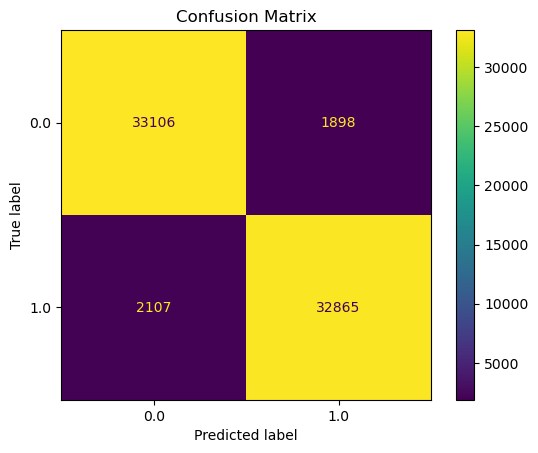

In [236]:
plot_confusion_matrix(rf, X, y)
plt.title('Confusion Matrix')
plt.show()

In [238]:
# Instantiate AdaBoost Classifier
abc = AdaBoostClassifier()

# Fit the model
abc.fit(X_train, y_train)

# Make predictions
y_pred = abc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7285653043726779


C:\Users\Ali Rizvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


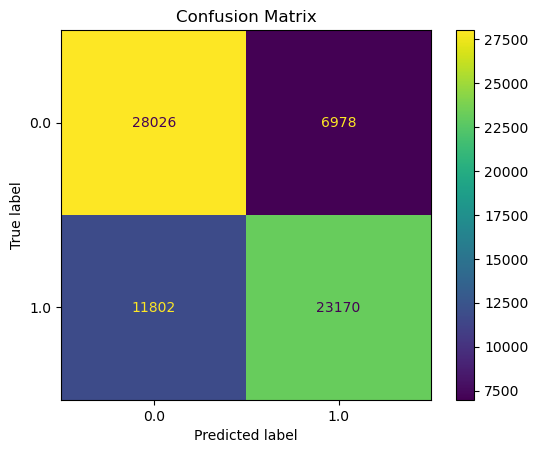

In [239]:
plot_confusion_matrix(abc, X, y)
plt.title('Confusion Matrix')
plt.show()